In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [2]:
%run -i ./ownlib/PHT-Library.ipynb

In [3]:
# Import images
ori_img = cv2.imread('./assets/lena.png', 0)
ori_logo = cv2.imread('./assets/squares.png', 0)

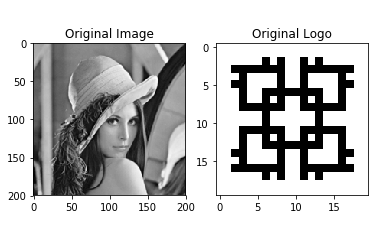

In [4]:
N = 200 # Image Size
G = 20 # Watermark Size

P = 2 * G
T_STEP = int(P / 4) + 1
I_STEP = int(N / 8) + 1

# Preprocess Image
IMG = cv2.resize(ori_img, (N, N))

# Preprocess Logo
LOGO = cv2.resize(ori_logo, (G,G))
LOGO = (LOGO >= 128) * 1

# Show Image and Logo
imshow2(IMG, LOGO, 'Original Image', 'Original Logo')

Progress: [####################] 100.0%


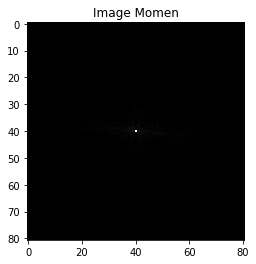

In [5]:
# Calculate Momen of Original Image
MOMEN = transformPHT(IMG, N, P)
imshow(MOMEN, 'Image Momen')

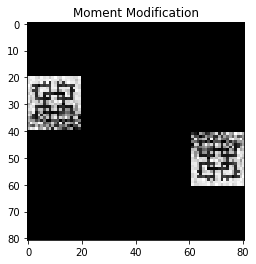

In [14]:
DELTA = 0.5 # Watermarking Power

# Current Binary Value
matQ = np.floor(np.abs(MOMEN) / DELTA) % 2

# Set Watermark Position
P2 = P * 2 + 1
# logo_position = np.index_exp[P+1+int(G/2):P+1+int(3*G/2), P+1+int(G/2):P+1+int(3*G/2)] # Middle-Center
logo_position = np.index_exp[P+1:P+1+G, P+1+G:P2] # Top - Right

# Watermark Matrix
doubleLogo = np.zeros((P2, P2))
doubleLogo[logo_position] = LOGO
doubleLogo = doubleLogo + np.rot90(np.rot90(doubleLogo))

# Watermark Filter matrix
doubleLogoFilter = np.zeros((P2, P2))
doubleLogoFilter[logo_position] = 1
doubleLogoFilter = doubleLogoFilter + np.rot90(np.rot90(doubleLogoFilter))
        
# Modified Momen
EPSILONE = np.abs(MOMEN) - np.floor(np.abs(MOMEN) / DELTA) * DELTA

OMEGA = - EPSILONE
OMEGA = OMEGA + DELTA / 2 * (matQ == doubleLogo)
OMEGA = OMEGA + 3 * DELTA / 2 * np.logical_and(matQ != doubleLogo, np.logical_or(EPSILONE > DELTA / 2, np.abs(MOMEN) < DELTA))
OMEGA = OMEGA - DELTA / 2 * np.logical_and(matQ != doubleLogo, np.logical_and(EPSILONE <= DELTA / 2, np.abs(MOMEN) >= DELTA))

OMEGA = OMEGA / np.abs(MOMEN) * MOMEN
OMEGA = OMEGA * doubleLogoFilter

# Show Modified Momen
imshow(OMEGA, 'Moment Modification')

Progress: [####################] 100.0%


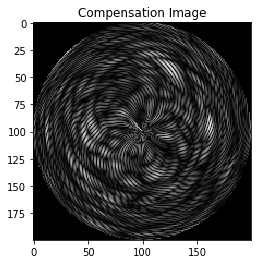

In [15]:
# Calculate Compensation Image
EPSILON = inversePHT(OMEGA, N, P)
imshow(EPSILON, 'Compensation Image')

In [16]:
def processAttack(IMG_MODIFIED, SIZE=N):
    
    # Calculate Momen
    MOMEN_MODIFIED = transformPHT(IMG_MODIFIED, SIZE, P)
    
    # Current Binary Value & Difference
    MAT_Q_MODIFIED = np.floor(np.abs(MOMEN_MODIFIED) / DELTA) % 2
    
    # Crop Watermark
    LOGO_MODIFIED = MAT_Q_MODIFIED[logo_position]
    
    # Calculate Bit Error Rate    
    BE = calcBE(LOGO, LOGO_MODIFIED)
    BER = BE / (G * G)
    
    return (LOGO_MODIFIED, BE, BER)

Progress: [####################] 100.0%


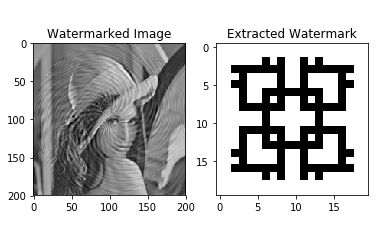

BE  :  0.0
BER :  0.00%


In [17]:
# Add Compensation Image to Original Image
IMG_WATERMARKED = IMG + EPSILON

(C_DIFF_WATERMARKED, BE_WATERMARKED, BER_WATERMARKED) = processAttack(IMG_WATERMARKED)

# Show Container
imshow2(IMG_WATERMARKED, C_DIFF_WATERMARKED, 'Watermarked Image', 'Extracted Watermark')

# Show Bit Error Rate
print('BE  : ', BE_WATERMARKED)
print('BER : ', '{:.2%}'.format(BER_WATERMARKED))

Progress: [####################] 100.0%


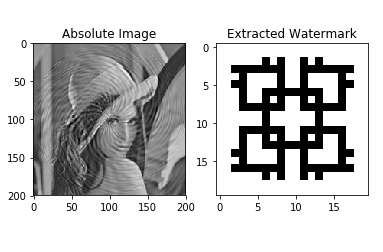

BE  :  0.0
BER :  0.00%


In [18]:
# Attack: Change Complex into Real Number
IMG_REAL = np.abs(IMG_WATERMARKED)

(C_DIFF_REAL, BE_REAL, BER_REAL) = processAttack(IMG_REAL)

# Show Container
imshow2(IMG_REAL, C_DIFF_REAL, 'Absolute Image', 'Extracted Watermark')

# Show Bit Error Rate
print('BE  : ', BE_REAL)
print('BER : ', '{:.2%}'.format(BER_REAL))

Progress: [####################] 100.0%


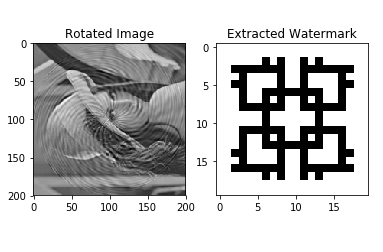

BE  :  0.0
BER :  0.00%


In [19]:
# Attack: Rotation 90 degree
IMG_ROTATE = np.rot90(IMG_WATERMARKED)

(C_DIFF_ROTATE, BE_ROTATE, BER_ROTATE) = processAttack(IMG_ROTATE)

# Show Container
imshow2(IMG_ROTATE, C_DIFF_ROTATE, 'Rotated Image', 'Extracted Watermark')

# Show Bit Error Rate
print('BE  : ', BE_ROTATE)
print('BER : ', '{:.2%}'.format(BER_ROTATE))

Progress: [####################] 100.0%


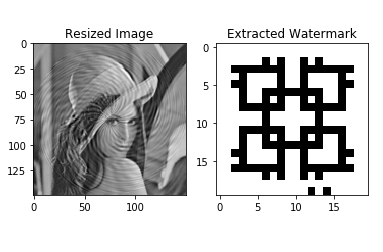

BE  :  2.0
BER :  0.50%


In [20]:
# Attack: Resize 75%
NN = 150
IMG_RESIZE = cv2.resize(np.abs(IMG_WATERMARKED), (NN, NN))

(C_DIFF_RESIZE, BE_RESIZE, BER_RESIZE) = processAttack(IMG_RESIZE, NN)

# Show Container
imshow2(IMG_RESIZE, C_DIFF_RESIZE, 'Resized Image', 'Extracted Watermark')

# Show Bit Error Rate
print('BE  : ', BE_RESIZE)
print('BER : ', '{:.2%}'.format(BER_RESIZE))

Progress: [####################] 100.0%


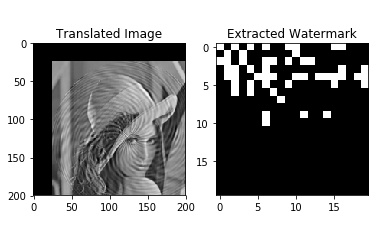

BE  :  258.0
BER :  64.50%


In [21]:
# Attack: Translation 12.5% X 12.5% Y
TRANSLATION_X = 25
TRANSLATION_Y = 25

IMG_TRANSLATION = np.zeros((N,N), dtype='complex128')
IMG_TRANSLATION[TRANSLATION_Y:N, TRANSLATION_X:N] = IMG_WATERMARKED[0:N-TRANSLATION_Y, 0:N-TRANSLATION_X]

(C_DIFF_TRANSLATION, BE_TRANSLATION, BER_TRANSLATION) = processAttack(IMG_TRANSLATION)

# Show Container
imshow2(IMG_TRANSLATION, C_DIFF_TRANSLATION, 'Translated Image', 'Extracted Watermark')

# Show Bit Error Rate
print('BE  : ', BE_TRANSLATION)
print('BER : ', '{:.2%}'.format(BER_TRANSLATION))

Progress: [####################] 100.0%


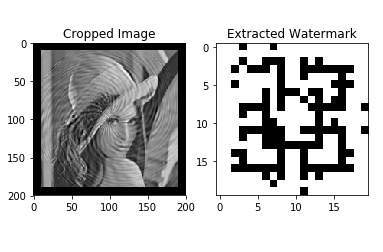

BE  :  27.0
BER :  6.75%


In [22]:
# Attack: FRAME 5%
CROP_WIDTH = 10

IMG_CROP = np.copy(IMG_WATERMARKED)
IMG_CROP[0:CROP_WIDTH,:] = 0
IMG_CROP[:,0:CROP_WIDTH] = 0
IMG_CROP[N-CROP_WIDTH:N,:] = 0
IMG_CROP[:,N-CROP_WIDTH:N] = 0

(C_DIFF_CROP, BE_CROP, BER_CROP) = processAttack(IMG_CROP)

# Show Container
imshow2(IMG_CROP, C_DIFF_CROP, 'Cropped Image', 'Extracted Watermark')

# Show Bit Error Rate
print('BE  : ', BE_CROP)
print('BER : ', '{:.2%}'.format(BER_CROP))

Progress: [####################] 100.0%


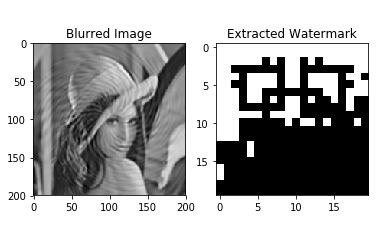

BE  :  138.0
BER :  34.50%


In [23]:
# Attack: BLUR 3x3
BLUR_KERNEL_SIZE = 3

IMG_BLUR = cv2.blur(np.abs(IMG_WATERMARKED), (BLUR_KERNEL_SIZE, BLUR_KERNEL_SIZE))

(C_DIFF_BLUR, BE_BLUR, BER_BLUR) = processAttack(IMG_BLUR)

# Show Container
imshow2(IMG_BLUR, C_DIFF_BLUR, 'Blurred Image', 'Extracted Watermark')

# Show Bit Error Rate
print('BE  : ', BE_BLUR)
print('BER : ', '{:.2%}'.format(BER_BLUR))

Progress: [####################] 100.0%


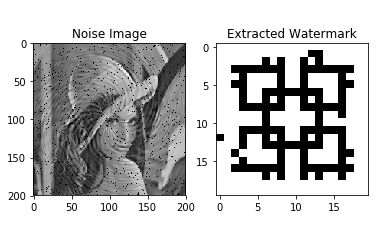

BE  :  6.0
BER :  1.50%


In [24]:
# Attack: RANDOM NOISE 3%

NOISE_PERCENTAGE = 3

IMG_NOISE = np.copy(IMG_WATERMARKED)
for i, row in enumerate(IMG_NOISE):
    for j, val in enumerate(row):
        if(np.random.randint(low=0, high=100) < NOISE_PERCENTAGE):
            IMG_NOISE[i,j] = 0

(C_DIFF_NOISE, BE_NOISE, BER_NOISE) = processAttack(IMG_NOISE)

# Show Container
imshow2(IMG_NOISE, C_DIFF_NOISE, 'Noise Image', 'Extracted Watermark')

# Show Bit Error Rate
print('BE  : ', BE_NOISE)
print('BER : ', '{:.2%}'.format(BER_NOISE))